In [26]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.special as ScSc
from tqdm import tqdm
from scipy.special import logsumexp


In [9]:
def LSE(X):
    x_max = max(X)
    diff = [math.exp(x-x_max) for x in X]
    sum = x_max + math.log(np.sum(diff))

    return sum


In [62]:
class GMM:
    """
    Diagonal Gaussian Mixture Model
    """

    def __init__(self, k, d, sigma_init = 0.1):
        self.num_cluster = k
        self.x_dim = d
        self.weights = ScSc.softmax(np.random.normal(scale = sigma_init, size=(k,)))
        self.means = np.random.normal(scale = sigma_init, size =(k, d))
        self.sigmas = np.random.lognormal(sigma=sigma_init, size=(k, d)) # All positive
        pi = np.random.rand(k)
        self.weights = pi / np.sum(pi)

        np.random.seed(0)
        self.means = np.random.normal(0, 3, size=(k, d))

        np.random.seed(0)
        self.sigmas = np.random.rand(k, d) + 0.5
    def EM(self, X, max_iter = 500, tol = 1e-5, eps = 1e-10):
        """
        EM Step
        """
        assert X.ndim == 2
        n = X.shape[0]
        assert X.shape[1] == self.x_dim

        loss = []
        rlog = np.zeros((n, self.num_cluster))
        r = np.zeros((n, self.num_cluster))
        for iter in (range(max_iter)):
        #     ###########
        #     # E Step
        #     ###########

            for k in range(self.num_cluster):
                rlog[:,k] = np.log(self.weights[k] + eps) - 0.5 * np.sum(np.log(self.sigmas[k] + eps)) - 0.5 * np.dot((X-self.means[k]) ** 2, 1/(self.sigmas[k] + eps))
            
            r_total = logsumexp(rlog, axis=1)
            rlog = rlog - r_total[:,None]
            loss.append(-np.sum(r_total))

            if iter > 1 and abs(loss[iter] - loss[iter-1]) <= tol * abs(loss[iter]):
                break
            
            r = np.exp(rlog)
            r_total_i_wise = np.sum(r, axis=0)
            self.weights = r_total_i_wise / n
            self.means = np.dot(r.T, X) / (r_total_i_wise[:,None] + eps)
            self.sigmas = np.dot(r.T, X ** 2) / (r_total_i_wise[:,None] + eps) - self.means ** 2
        #     for k in range(self.num_cluster):

        #         # Updating rik
        #         partition = np.log(self.weights[k]+eps) - 0.5*np.log(self.sigmas[k, :]+eps).sum()
        #         s = 1/ (self.sigmas[k, :] + eps)
        #         delta = X - self.means[k][np.newaxis, :]
        #         exp_term = np.sum(delta * delta * s[np.newaxis, :], axis = -1)
        #         rlog[:, k] = -0.5 * exp_term + partition

        #     # Normalize
        #     rlogsum = []
        #     for i in range(n):
        #         ri_log = LSE(rlog[i])
        #         rlogsum.append(ri_log)
        #     rlogsum = np.array(rlogsum)
        #     assert rlogsum.shape == (n,)
        #     rlogsum = np.array(rlogsum)
        #     rlog = rlog - rlogsum[:, np.newaxis]
        #     loss = -np.sum(rlogsum)
        #     loss_hist.append(loss)

            
        #     # Convert back to exp form
        #     for i in range(n):
        #         for k in range(self.num_cluster):
        #             r[i, k] = np.exp(rlog[i, k])
            
        #     if it > 0 and abs(loss_hist[-1] - loss_hist[-2]) <= tol * abs(loss_hist[-1]):
        #         break

        #     ###########
        #     # M Step
        #     ###########
        #     rsum = np.sum(r, axis = 0)
        #     assert rsum.shape == (self.num_cluster,)
        #     self.weights = rsum/n

        #     for k in range(self.num_cluster):
        #         self.means[k, :] = np.sum(r[:, k, np.newaxis] * X, axis = 0) / (rsum[k] + eps)
        #         self.sigmas[k, :] = np.sum(r[:, k, np.newaxis] * X * X, axis = 0) / (rsum[k] + eps) - self.means[k, :] * self.means[k, :]

        return loss
    
    def sort_weights(self):
        """
        Sort the parameters according to their weights
        """
        order = np.argsort(self.weights)[::-1]
        self.weights = self.weights[order]
        self.means = self.means[order]
        self.sigmas = self.sigmas[order]
    
    def posterior(self, x):
        eps = 1e-8
        p = 0
        for k in range(self.num_cluster):
            det = (2*math.pi) ** 20 * np.prod(self.sigmas[k])
            s = 1/ (self.sigmas[k, :] + eps)
            delta = x - self.means[k]
            exp_term = -0.5 * np.sum(delta * delta * s[np.newaxis, :], axis = -1)
            prob = 1/math.sqrt(det+eps) * math.exp(exp_term)
            p += self.weights[k]*prob
        return p
    
    # def pdf(self, x):
    #     assert x.ndim == 2
    #     n = x.shape[0]
    #     assert x.shape[1] == self.x_dim
        
    #     r = np.zeros((n,self.num_cluster))
    #     for j in range(self.num_cluster):
    #         partition = np.log(self.weights[j]) - 0.5 * np.log(self.sigmas[j,:]).sum()
            
    #         s = 1 / self.sigmas[j,:]
    #         form = x - self.means[j][np.newaxis,:]
    #         form = np.sum(form * form * s[np.newaxis,:], axis=-1)
    #         r[:,j] = np.exp(-0.5 * form + partition)
            
    #     return np.sum(r * self.weights[np.newaxis,:], axis=-1)
            

In [11]:
data = np.loadtxt('gmm_dataset.csv', delimiter=",")


FileNotFoundError: gmm_dataset.csv not found.

In [12]:
gmms = []
losses_overk = []
for k in range(1, 11):
    print("Constructing GMM with k =", k)
    gmm = GMM(k, 20)
    loss = gmm.EM(data)
    losses_overk.append(loss[-1])
    gmms.append(gmm)

Constructing GMM with k = 1


NameError: name 'data' is not defined

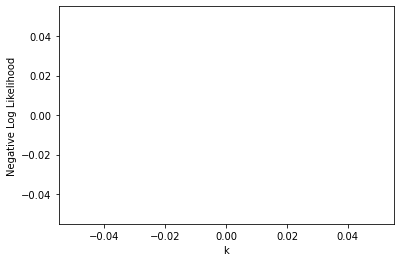

[]


In [13]:
plt.plot(losses_overk)
plt.ylabel("Negative Log Likelihood")
plt.xlabel("k")
plt.show()
print(losses_overk)



In [14]:
print("Choose k = 5")
chosen_gmm = gmms[4]
chosen_gmm.sort_weights()
print("Weights:")
print(chosen_gmm.weights)
print("Means:")
print(chosen_gmm.means)
print("Covariances:")
print(chosen_gmm.sigmas)

Choose k = 5


IndexError: list index out of range

# Using GMM on MNIST

In [15]:
# Import datasets and reduce by PCA
import torch
import numpy as np

import torchvision.datasets as datasets

root = './data'
train_data = datasets.MNIST(root = root, train= True, transform=None, download=True)
test_data = datasets.MNIST(root = root, train= False, transform=None, download=True)

train_X = train_data.data
train_Y = train_data.targets
train_X = np.reshape(train_X, (60000, 784))
test_X = test_data.data
test_Y = test_data.targets
test_X = np.reshape(test_X, (10000, 784))

from sklearn.decomposition import PCA 

d = 40

reducer = PCA(n_components=d)
reducer.fit(train_X)

train_data_reduced = reducer.transform(train_X)
test_data_reduced = reducer.transform(test_X)

label_set = set(train_Y)
train_Y = train_Y.numpy()
test_Y = test_Y.numpy()

In [16]:
train_x_split = np.array([[]*10])
print(train_x_split.shape)

(1, 0)


In [20]:
def split_training_set(train_x, train_y):
    train_x_split = [[] for _ in range(10)]
    for i in range(len(train_y)):
        train_x_split[train_y[i]].append(train_x[i])
    return train_x_split

def train_baysianGMM(train_x, train_y, k):
    gmms = []
    d = len(train_x[0])

    train_x_by_classes = split_training_set(train_x, train_y)

    # Calculate P(Y=c)
    total = len(train_x)
    P_yc = []
    for x_c in train_x_by_classes:
        P_yc.append(len(x_c)/total)

    print("------- Training ------")
    # Train gmm for each class
    for c in tqdm(range(len(train_x_by_classes))):
        train_x_class_c = np.array(train_x_by_classes[c])
        gmm_c = GMM(k, d)
        gmm_c.EM(train_x_class_c)
        gmms.append(gmm_c)

    return gmms, P_yc

def baysianGMM_classifier(x, gmms, P_yc):
    largest_prob = -1
    chosen_c = -1
    for c in range(len(gmms)):
        gmm_c = gmms[c]
        prob = gmm_c.posterior(x) * P_yc[c]
        if prob > largest_prob:
            largest_prob = prob
            chosen_c = c
    
    return chosen_c

def report_test_err(test_X, test_Y, gmms, P_yc):
    pred_Y = []
    print("------- Testing ------")
    for x in tqdm(test_X):
        y_hat = baysianGMM_classifier(x, gmms, P_yc)
        pred_Y.append(y_hat)

    err_count = 0
    for y_hat, y in zip(pred_Y, test_Y):
        if y_hat != y:
            err_count += 1
    
    return err_count/len(test_Y)

def train_and_test(train_data, train_label, test_data, test_label):
    err_list = []
    for k in (range(1, 11)):
        print("============= Train and Test for k =", k, "===============")
        gmms, p_yc= train_baysianGMM(train_data, train_label, k)
        err = report_test_err(test_data, test_label, gmms, p_yc)
        err_list.append(err)
        print("For k=", k, "Error is:", err)


    return err_list


In [60]:
# train_and_test(train_data_reduced, train_Y, test_data_reduced, test_Y)
gmms, p_yc= train_baysianGMM(train_data_reduced, train_Y, 5)   
    

------- Training ------


100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


In [63]:
err_list = train_and_test(train_data_reduced, train_Y, test_data_reduced, test_Y)

============= Train and Test for k = 1 ===============
------- Training ------


100%|██████████| 10/10 [00:00<00:00, 149.22it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:01<00:00, 7998.21it/s]


For k= 1 Error is: 0.1247
============= Train and Test for k = 2 ===============
------- Training ------


100%|██████████| 10/10 [00:00<00:00, 15.48it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:02<00:00, 4074.07it/s]


For k= 2 Error is: 0.1123
============= Train and Test for k = 3 ===============
------- Training ------


100%|██████████| 10/10 [00:01<00:00,  9.49it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:03<00:00, 2705.75it/s]


For k= 3 Error is: 0.0921
============= Train and Test for k = 4 ===============
------- Training ------


100%|██████████| 10/10 [00:01<00:00,  7.93it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:04<00:00, 2048.30it/s]


For k= 4 Error is: 0.0895
============= Train and Test for k = 5 ===============
------- Training ------


100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:06<00:00, 1658.83it/s]


For k= 5 Error is: 0.0859
============= Train and Test for k = 6 ===============
------- Training ------


100%|██████████| 10/10 [00:01<00:00,  5.34it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:07<00:00, 1384.35it/s]


For k= 6 Error is: 0.0783
============= Train and Test for k = 7 ===============
------- Training ------


100%|██████████| 10/10 [00:02<00:00,  4.23it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:08<00:00, 1198.20it/s]


For k= 7 Error is: 0.0764
============= Train and Test for k = 8 ===============
------- Training ------


100%|██████████| 10/10 [00:02<00:00,  4.71it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:09<00:00, 1047.32it/s]


For k= 8 Error is: 0.0717
============= Train and Test for k = 9 ===============
------- Training ------


100%|██████████| 10/10 [00:02<00:00,  3.84it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:10<00:00, 931.50it/s]


For k= 9 Error is: 0.0692
============= Train and Test for k = 10 ===============
------- Training ------


100%|██████████| 10/10 [00:03<00:00,  2.65it/s]


------- Testing ------


100%|██████████| 10000/10000 [00:11<00:00, 838.60it/s]

For k= 10 Error is: 0.0684
